In [1]:
from pathlib import Path

from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.datasets import load_data
import numpy as np
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError

import matplotlib.pyplot as plt

In [2]:
(X, Y), (X_val, Y_val) = load_data('mnist', flatten=False)

In [10]:
map_size = (8, 8)
latent_dim = 10
input_shape = X.shape[1:]
autoencoder, encoder, decoder = conv2d_autoencoder(input_shape, latent_dim, [32, 64, 64], 3, 2)
autoencoder.compile('adam', 'mse')
save_dir = 'results/tmp'
epochs = 1
batch_size = 256
save_file = Path(f'{save_dir}/ae_weights-epoch{epochs}.h5')
if save_file.is_file():
    autoencoder.load_weights(save_file)
else:
    autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)
    # autoencoder.save_weights(save_file)
som_layer = SOMLayer(map_size, name='som')(encoder.output)
model = Model(
    inputs=autoencoder.input, outputs=[autoencoder.output, som_layer]
)
model.compile(
    loss={"decoder_0": "mse", "som": 'mse'},
    loss_weights=[1, 0.],
    optimizer='adam',
)

2023-06-14 18:18:17.396285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 74ms/step


2023-06-14 18:18:33.683716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


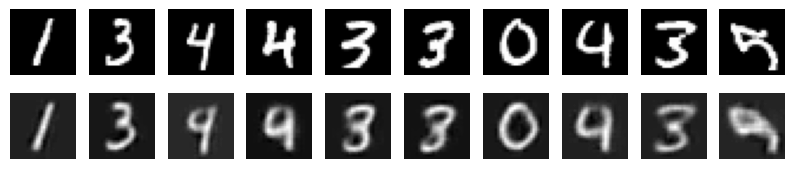

In [11]:
indices = np.random.randint(len(X), size=10)
theseX = X[indices]
theseXp = autoencoder.predict(theseX)
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for x, xp, axs in zip(theseX, theseXp, axes.T):
    axs[0].imshow(x, cmap='gray')
    axs[1].imshow(xp, cmap='gray')
    for ax in axs:
        ax.axis('off')

In [12]:
epochs = 5
batch_size = 256
for layer in model.layers[:-1]:
    layer.trainable = False
model.fit(X, [X, Y], epochs=epochs, batch_size=batch_size, verbose=0)

2023-06-14 18:18:44.411190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [13]:
images = decoder.predict(model.get_layer(name='som').get_weights()[0])

2/2 [==============================] - 0s 6ms/step


2023-06-14 18:20:02.758892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


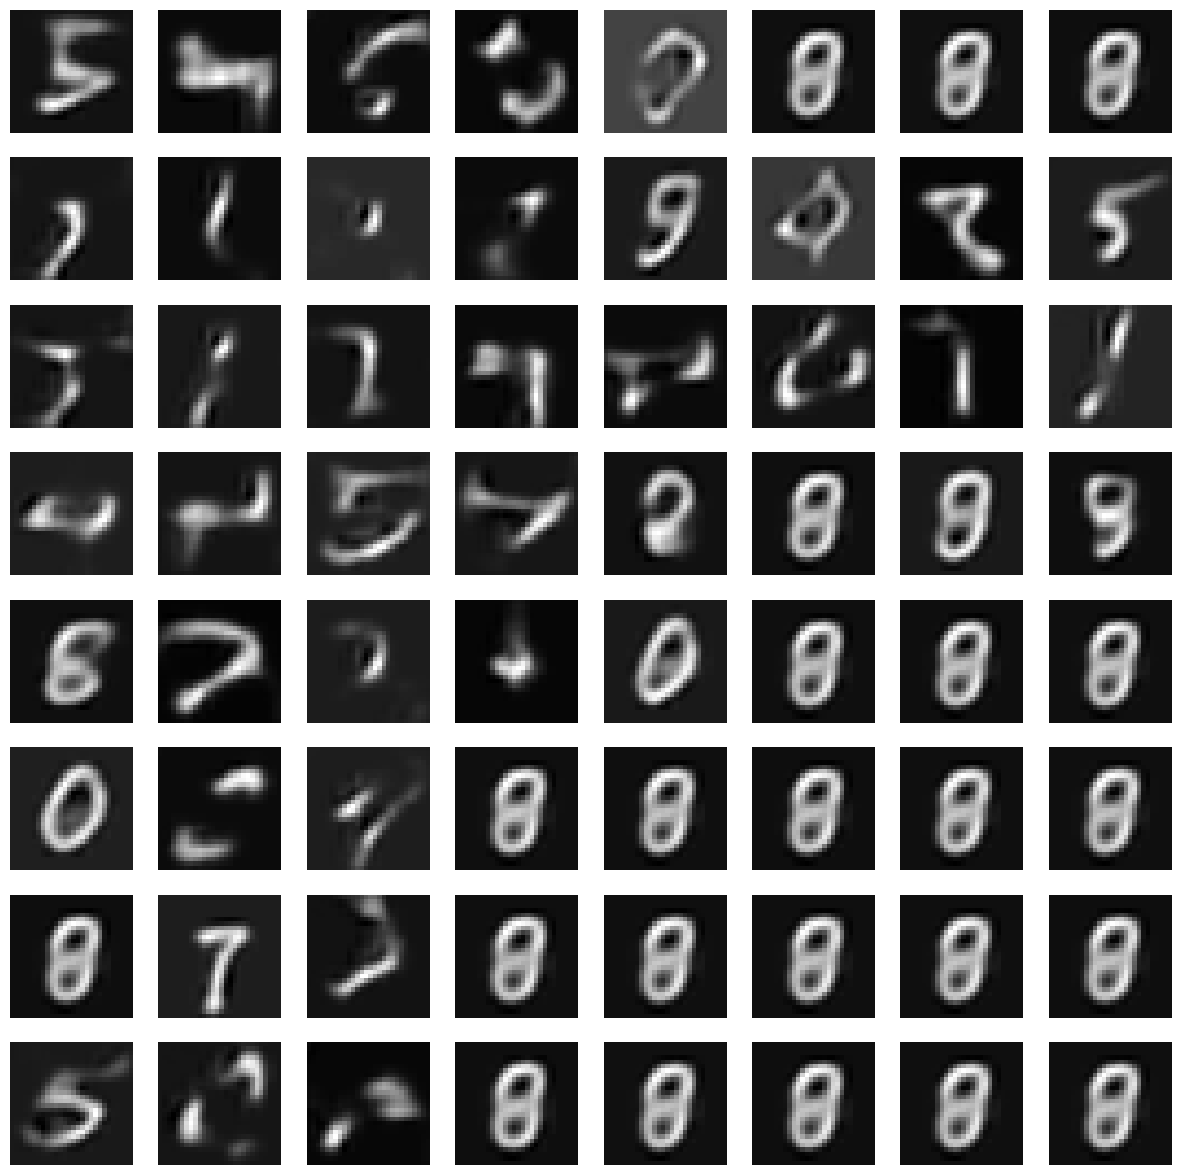

In [14]:
fig, axes = plt.subplots(*map_size, figsize=(15, 15))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im, cmap='gray')
    ax.axis('off')